## Data Preprocessing

Data Srouces:
* JHU Covid Case Data
* Apple Mobility Data
* Vaccinations Data from OWID
* Google Trends Data

In [2]:
# Import necessities
import os
import datetime
import pickle as pkl
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# Set plotting style
sns.set_style('whitegrid')
sns.set_palette('Set2')

In [3]:
# All file paths of raw data
data_path = {
    'confirmed': './data/time_series_covid19_confirmed_global.csv',
    'deaths': './data/time_series_covid19_deaths_global.csv',
    'recovered': './data/time_series_covid19_recovered_global.csv',
    'mobility': './data/applemobilitytrends-2021-03-19.csv',
    'vaccination': './data/country_vaccinations.csv',
    'trends': './data/trends_data.csv',
    'owid': './data/owid-covid-data.csv',
}

# Reading in data in csv format
data_df = dict()
for key, value in data_path.items():
    data_df[key] = pd.read_csv(value)

# Droppoing useless columns
data_df['confirmed'] = data_df['confirmed'].iloc[:, 4:-3]
data_df['deaths'] = data_df['deaths'].iloc[:, 4:-3]
data_df['recovered'] = data_df['recovered'].iloc[:, 4:-3]
data_df['mobility'] = data_df['mobility'].iloc[:, 6:-3]

C:\Users\Gao\AppData\Local\Programs\Python\Python36\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
# Dataset construction
dates = data_df['confirmed'].keys()
# 
dataset = pd.DataFrame({'dates': dates})

# Calculate the total number of differet group
for split in ['confirmed', 'deaths', 'recovered']:
    dataset[split] = data_df[split].apply(lambda x:x.sum()).values
dataset['unrecovered'] = dataset['confirmed'] - dataset['deaths'] - dataset['recovered']
# Calculate the increments of each group to the previous day
for split in ['confirmed', 'deaths', 'recovered', 'unrecovered']:
    # Calculating the increments by subtracting the shifted column from the original one
    dataset[split + '_increment'] = (dataset[split] - dataset[split].shift(1)).values
    # The first element is NaN and should be modified to 0
    dataset[split + '_increment'].iloc[0] = 0
# Calculate the death rate and recovered rate
dataset['death_rate'] = dataset['deaths'] / dataset['confirmed']
dataset['recovered_rate'] = dataset['recovered'] / dataset['confirmed']

# Add mobilities to the dataset
dataset.loc[:,'mobility'] = data_df['mobility'].sum().values[9:]

# Add vaccinations to the dataset
# Calculate the total number of vaccinated people
dataset['vaccinations'] = 0
vaccinations = data_df['vaccination'].groupby('date').agg('sum')['people_vaccinated'][:-3].cumsum()
dataset.loc[dataset[dataset['dates']=='12/13/20'].index[0]:,'vaccinations'] = vaccinations.values

# Add trends data to the dataset
dataset['trends_covid'] = data_df['trends']['COVID']
dataset['trends_vaccine'] = data_df['trends']['vaccine']

# Change dates to integers [0, len(dates)]
dataset['dates'] = [i for i in range(len(dates))]

# Calculate average with sliding windows to smooth the data
dataset_rolling = dataset.rolling(7, min_periods=0).mean()

C:\Users\Gao\AppData\Local\Programs\Python\Python36\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [20]:
dataset.to_csv('./data/dataset.csv')
dataset_rolling.to_csv('./data/dataset_rolling.csv')

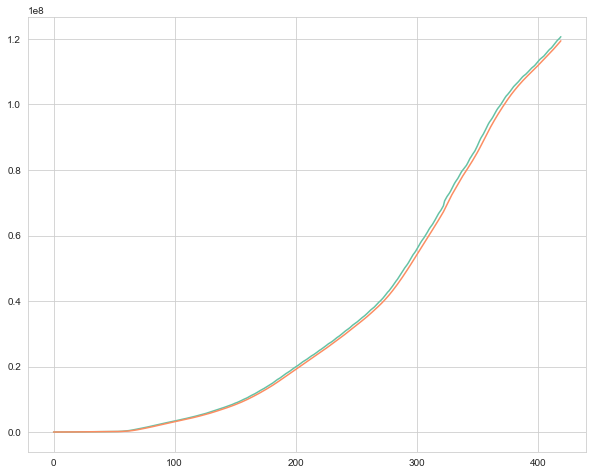

In [16]:
plt.figure(figsize=(10, 8))
plot_target = 'confirmed'
plt.plot(dataset[plot_target])
plt.plot(dataset_rolling[plot_target])
# plt.plot(dataset_rolling['mobility'])